In [1]:
# EIGO System v1 — Cloud Build
# Zero money. Google Colab only.

!pip install yfinance fredapi --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime

plt.style.use("seaborn-v0_8")

print("EIGO v1 initialized.")

EIGO v1 initialized.


In [2]:
# SECTION 2 — Global Data Layer

def fetch_global_data():

    tickers = [
        "^GSPC",   # US Equity
        "^NSEI",   # India Equity
        "^VIX",    # Volatility
        "^TNX",    # US 10Y Yield
        "GC=F",    # Gold
        "HYG",     # High Yield Credit
        "LQD"      # Investment Grade Credit
    ]

    start_date = "2010-01-01"
    end_date = datetime.today().strftime("%Y-%m-%d")

    raw = yf.download(tickers, start=start_date, end=end_date)

    # Use Close for stability
    data = raw["Close"].copy()

    # Drop rows with missing values
    data = data.dropna()

    return data


data = fetch_global_data()

data.tail()

/tmp/ipython-input-488785755.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  7 of 7 completed


Ticker,GC=F,HYG,LQD,^GSPC,^NSEI,^TNX,^VIX
Date,,,,,,,
2026-02-17,4882.899902,80.809998,111.699997,6843.220215,25725.400391,4.052,20.290001
2026-02-18,4986.500000,80.910004,111.589996,6881.310059,25819.349609,4.079,19.620001
2026-02-19,4975.899902,80.940002,111.680000,6861.890137,25454.349609,4.075,20.230000
2026-02-20,5059.299805,81.000000,111.589996,6909.509766,25571.250000,4.086,19.090000
2026-02-23,5204.700195,80.870003,111.709999,6837.750000,25713.000000,4.029,21.010000


In [3]:
# SECTION 3 — Structural Fragility Engine

def compute_returns(data):
    returns = data.pct_change().dropna()
    return returns

returns = compute_returns(data)

returns.tail()

Ticker,GC=F,HYG,LQD,^GSPC,^NSEI,^TNX,^VIX
Date,,,,,,,
2026-02-17,-0.027698,-0.000495,0.000986,0.001031,0.009984,-0.000986,-0.015049
2026-02-18,0.021217,0.001238,-0.000985,0.005566,0.003652,0.006663,-0.033021
2026-02-19,-0.002126,0.000371,0.000807,-0.002822,-0.014137,-0.000981,0.031091
2026-02-20,0.016761,0.000741,-0.000806,0.006940,0.004593,0.002699,-0.056352
2026-02-23,0.028739,-0.001605,0.001075,-0.010386,0.005543,-0.013950,0.100576


In [4]:
def compute_volatility_signal(returns, window=30):
    rolling_vol = returns.rolling(window).std()
    vol_signal = rolling_vol.mean(axis=1)
    return vol_signal

vol_signal = compute_volatility_signal(returns)

vol_signal.tail()

,0
Date,
2026-02-17,0.020901
2026-02-18,0.020897
2026-02-19,0.020875
2026-02-20,0.020966
2026-02-23,0.021282


In [5]:
def compute_correlation_signal(returns, window=30):

    corr_values = []
    index_vals = returns.index[window:]

    for i in range(window, len(returns)):
        window_data = returns.iloc[i-window:i]
        corr_matrix = window_data.corr().values

        avg_corr = np.mean(
            np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
        )

        corr_values.append(avg_corr)

    corr_signal = pd.Series(corr_values, index=index_vals)

    return corr_signal

corr_signal = compute_correlation_signal(returns)

corr_signal.tail()

,0
Date,
2026-02-17,0.246674
2026-02-18,0.242377
2026-02-19,0.243556
2026-02-20,0.244749
2026-02-23,0.252468


In [6]:
def compute_credit_signal(data, window=30):

    credit_ratio = data["HYG"] / data["LQD"]
    credit_signal = credit_ratio.pct_change().rolling(window).mean()

    return credit_signal

credit_signal = compute_credit_signal(data)

credit_signal.tail()

,0
Date,
2026-02-17,-0.000226
2026-02-18,-0.000261
2026-02-19,-0.000301
2026-02-20,-0.000242
2026-02-23,-0.000340


In [7]:
def compute_fragility_index(vol_signal, corr_signal, credit_signal):

    fragility_df = pd.DataFrame({
        "Volatility": vol_signal,
        "Correlation": corr_signal,
        "CreditStress": credit_signal
    }).dropna()

    scaler = StandardScaler()
    scaled = scaler.fit_transform(fragility_df)

    fragility_raw = pd.Series(
        scaled.mean(axis=1),
        index=fragility_df.index
    )

    # Normalize to 0–100
    fragility_score = 100 * (
        fragility_raw - fragility_raw.min()
    ) / (
        fragility_raw.max() - fragility_raw.min()
    )

    # Smooth for structural stability
    fragility_smooth = fragility_score.rolling(15).mean().dropna()

    return fragility_smooth


fragility = compute_fragility_index(
    vol_signal, corr_signal, credit_signal
)

fragility.tail()

,0
Date,
2026-02-17,23.682060
2026-02-18,22.526328
2026-02-19,21.353072
2026-02-20,20.350932
2026-02-23,19.303885


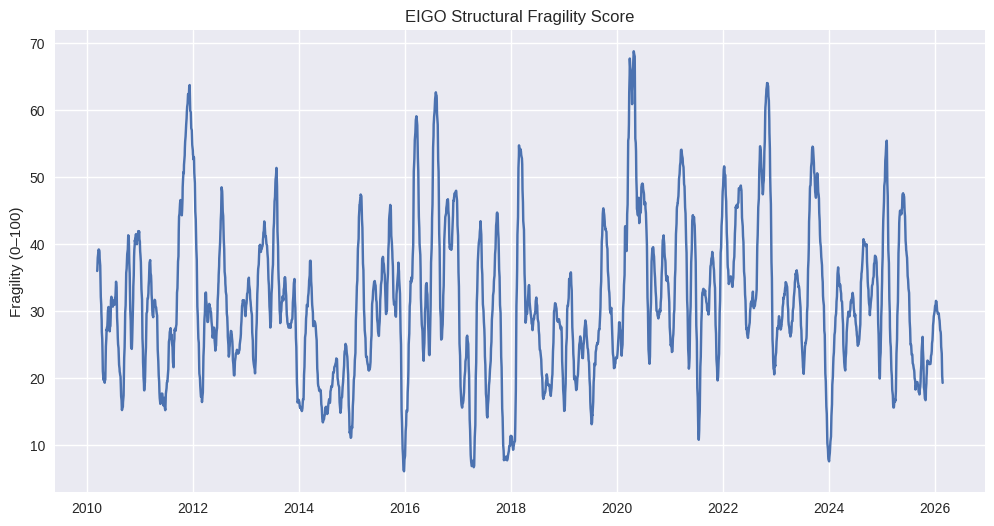

In [8]:
plt.figure(figsize=(12,6))
plt.plot(fragility)
plt.title("EIGO Structural Fragility Score")
plt.ylabel("Fragility (0–100)")
plt.show()

In [9]:
def compute_fragility_index(vol_signal, corr_signal, credit_signal):

    fragility_df = pd.DataFrame({
        "Volatility": vol_signal,
        "Correlation": corr_signal,
        "CreditStress": credit_signal
    }).dropna()

    scaler = StandardScaler()
    scaled = scaler.fit_transform(fragility_df)

    fragility_raw = pd.Series(
        scaled.mean(axis=1),
        index=fragility_df.index
    )

    # Normalize to 0–100
    fragility_score = 100 * (
        fragility_raw - fragility_raw.min()
    ) / (
        fragility_raw.max() - fragility_raw.min()
    )

    # Increased smoothing window (more structural stability)
    fragility_smooth = fragility_score.rolling(20).mean().dropna()

    return fragility_smooth

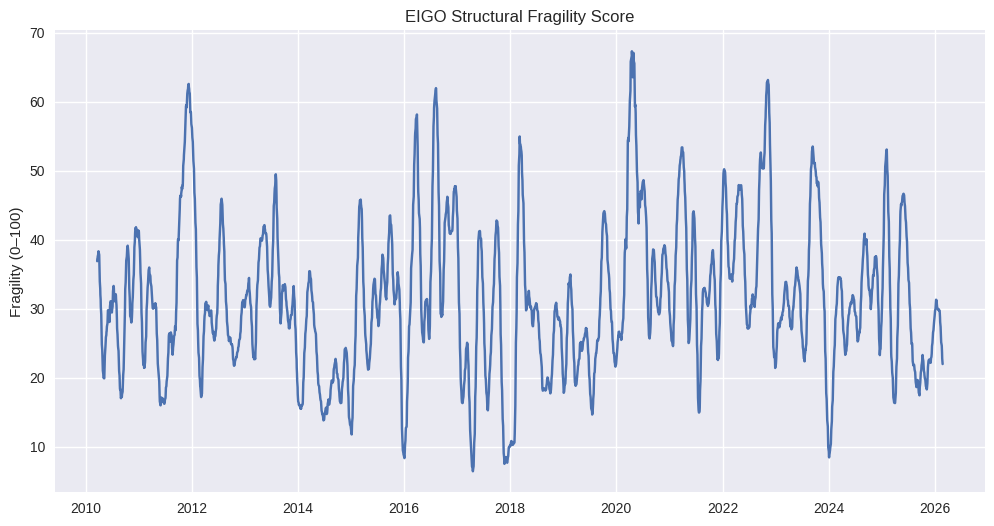

In [10]:
fragility = compute_fragility_index(
    vol_signal, corr_signal, credit_signal
)

plt.figure(figsize=(12,6))
plt.plot(fragility)
plt.title("EIGO Structural Fragility Score")
plt.ylabel("Fragility (0–100)")
plt.show()

In [11]:
# SECTION 4 — Regime Intelligence Engine

def compute_regime_features(fragility_series):

    fragility_momentum = fragility_series.diff()

    regime_df = pd.DataFrame({
        "Level": fragility_series,
        "Momentum": fragility_momentum
    }).dropna()

    return regime_df


regime_df = compute_regime_features(fragility)

regime_df.tail()

,Level,Momentum
Date,,
2026-02-17,24.637687,-0.498201
2026-02-18,24.194188,-0.443499
2026-02-19,23.595418,-0.598770
2026-02-20,22.789069,-0.806349
2026-02-23,21.971759,-0.817310


In [12]:
def compute_regimes(regime_df, n_clusters=4):

    scaler = StandardScaler()
    scaled = scaler.fit_transform(regime_df)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    regime_labels = kmeans.fit_predict(scaled)

    regime_df["Regime"] = regime_labels

    return regime_df


regime_df = compute_regimes(regime_df)

regime_df.tail()

,Level,Momentum,Regime
Date,,,
2026-02-17,24.637687,-0.498201,1
2026-02-18,24.194188,-0.443499,1
2026-02-19,23.595418,-0.598770,1
2026-02-20,22.789069,-0.806349,2
2026-02-23,21.971759,-0.817310,2


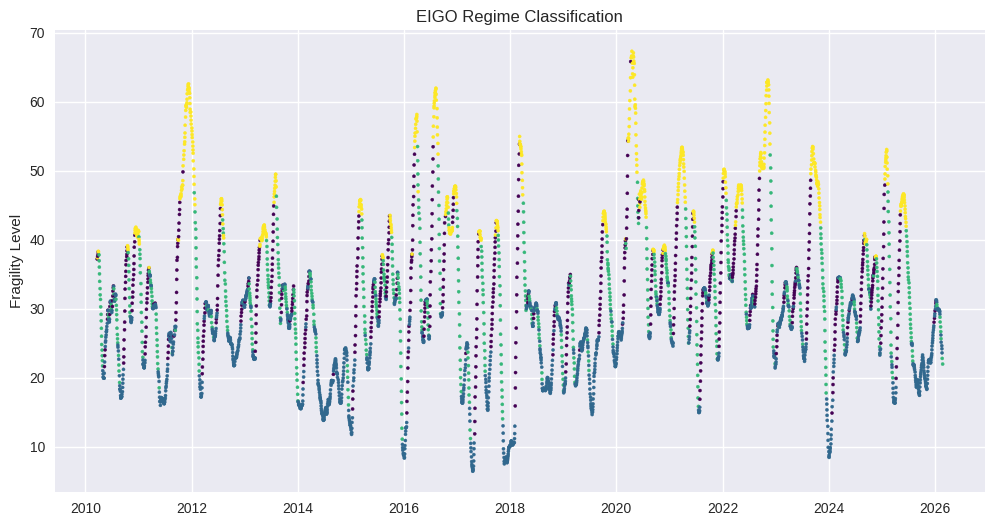

In [13]:
plt.figure(figsize=(12,6))

plt.scatter(
    regime_df.index,
    regime_df["Level"],
    c=regime_df["Regime"],
    cmap="viridis",
    s=5
)

plt.title("EIGO Regime Classification")
plt.ylabel("Fragility Level")
plt.show()

In [14]:
regime_df.groupby("Regime")["Level"].mean().sort_values()

,Level
Regime,
1,23.176882
2,31.583026
0,33.394118
3,48.526693


In [15]:
# Map regimes based on sorted fragility means

regime_means = regime_df.groupby("Regime")["Level"].mean().sort_values()
ordered_regimes = regime_means.index.tolist()

regime_labels_map = {
    ordered_regimes[0]: "Stable",
    ordered_regimes[1]: "Compression",
    ordered_regimes[2]: "Elevated",
    ordered_regimes[3]: "Fragile"
}

regime_df["RegimeLabel"] = regime_df["Regime"].map(regime_labels_map)

regime_df.tail()

,Level,Momentum,Regime,RegimeLabel
Date,,,,
2026-02-17,24.637687,-0.498201,1,Stable
2026-02-18,24.194188,-0.443499,1,Stable
2026-02-19,23.595418,-0.598770,1,Stable
2026-02-20,22.789069,-0.806349,2,Compression
2026-02-23,21.971759,-0.817310,2,Compression


In [16]:
current_regime = regime_df["RegimeLabel"].iloc[-1]
current_fragility = fragility.iloc[-1]

current_regime, current_fragility

('Compression', np.float64(21.971759367954895))

In [17]:
def compute_transition_matrix(regime_df):

    regime_series = regime_df["RegimeLabel"]

    transition_matrix = pd.crosstab(
        regime_series.shift(1),
        regime_series,
        normalize="index"
    )

    return transition_matrix


transition_matrix = compute_transition_matrix(regime_df)

transition_matrix

RegimeLabel,Compression,Elevated,Fragile,Stable
RegimeLabel,,,,
Compression,0.841549,0.004695,0.008216,0.145540
Elevated,0.005019,0.855709,0.057716,0.081556
Fragile,0.065183,0.019078,0.915739,0.000000
Stable,0.059908,0.064516,0.000000,0.875576


In [18]:
current_regime = regime_df["RegimeLabel"].iloc[-1]

fracture_probability = transition_matrix.loc[current_regime, "Fragile"]

fracture_probability

np.float64(0.008215962441314555)

In [19]:
# SECTION 5 — Capital Survival Engine

def compute_portfolio_returns(returns):

    portfolio_assets = ["^GSPC", "^NSEI", "GC=F", "HYG", "LQD"]

    portfolio_data = returns[portfolio_assets]

    weights = np.ones(len(portfolio_assets)) / len(portfolio_assets)

    portfolio_returns = portfolio_data.dot(weights)

    return portfolio_returns


portfolio_returns = compute_portfolio_returns(returns)

portfolio_returns.tail()

,0
Date,
2026-02-17,-0.003238
2026-02-18,0.006138
2026-02-19,-0.003581
2026-02-20,0.005646
2026-02-23,0.004673


In [20]:
def compute_stressed_volatility(portfolio_returns, fragility):

    base_vol = portfolio_returns.rolling(30).std().iloc[-1]

    latest_fragility = fragility.iloc[-1]

    stress_multiplier = 1 + (latest_fragility / 100)

    stressed_vol = base_vol * stress_multiplier

    return stressed_vol


stressed_vol = compute_stressed_volatility(portfolio_returns, fragility)

stressed_vol

np.float64(0.008683161264286863)

In [21]:
def simulate_capital_survival(portfolio_returns, stressed_vol,
                              simulations=3000, days=60,
                              initial_capital=1_000_000):

    np.random.seed(42)

    simulated_end_values = []

    mean_return = portfolio_returns.mean()

    for _ in range(simulations):

        simulated_returns = np.random.normal(
            loc=mean_return,
            scale=stressed_vol,
            size=days
        )

        portfolio_path = initial_capital * np.cumprod(1 + simulated_returns)

        simulated_end_values.append(portfolio_path[-1])

    simulated_end_values = np.array(simulated_end_values)

    survival_threshold = 0.8 * initial_capital

    survival_probability = np.mean(
        simulated_end_values > survival_threshold
    )

    return survival_probability


survival_probability = simulate_capital_survival(
    portfolio_returns, stressed_vol
)

survival_probability

np.float64(1.0)

In [22]:
def simulate_capital_survival_curve(portfolio_returns, stressed_vol,
                                    simulations=3000, days=60,
                                    initial_capital=1_000_000):

    np.random.seed(42)

    simulated_end_values = []

    mean_return = portfolio_returns.mean()

    for _ in range(simulations):

        simulated_returns = np.random.normal(
            loc=mean_return,
            scale=stressed_vol,
            size=days
        )

        portfolio_path = initial_capital * np.cumprod(1 + simulated_returns)

        simulated_end_values.append(portfolio_path[-1])

    simulated_end_values = np.array(simulated_end_values)

    thresholds = [0.95, 0.90, 0.85, 0.80]

    survival_results = {}

    for t in thresholds:
        survival_results[f"Survival > {int(t*100)}%"] = np.mean(
            simulated_end_values > (t * initial_capital)
        )

    return survival_results


survival_curve = simulate_capital_survival_curve(
    portfolio_returns, stressed_vol
)

survival_curve

{'Survival > 95%': np.float64(0.856),
 'Survival > 90%': np.float64(0.966),
 'Survival > 85%': np.float64(0.9973333333333333),
 'Survival > 80%': np.float64(1.0)}

In [23]:
# SECTION 6 — Unified EIGO Intelligence

def build_eigo_intelligence(fragility,
                            current_regime,
                            fracture_probability,
                            survival_curve):

    intelligence = {
        "Current Fragility Score": float(round(fragility.iloc[-1], 2)),
        "Current Regime": current_regime,
        "Fracture Probability (Next State)": float(round(fracture_probability, 4)),
        "Capital Survival Surface": survival_curve
    }

    return intelligence


eigo_intelligence = build_eigo_intelligence(
    fragility,
    current_regime,
    fracture_probability,
    survival_curve
)

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)}}

In [24]:
# SECTION 7 — Fragility Evolution Engine

def simulate_fragility_evolution(fragility,
                                 simulations=2000,
                                 days=60):

    np.random.seed(42)

    current_value = fragility.iloc[-1]
    mean_level = fragility.mean()

    fragility_changes = fragility.diff().dropna()
    volatility = fragility_changes.std()

    alpha = 0.05  # mean reversion strength

    future_paths = []

    for _ in range(simulations):

        path = [current_value]

        for _ in range(days):

            shock = np.random.normal(0, volatility)
            drift = alpha * (mean_level - path[-1])

            next_value = path[-1] + drift + shock

            # Bound between 0 and 100
            next_value = max(0, min(100, next_value))

            path.append(next_value)

        future_paths.append(path)

    future_paths = np.array(future_paths)

    return future_paths


future_paths = simulate_fragility_evolution(fragility)

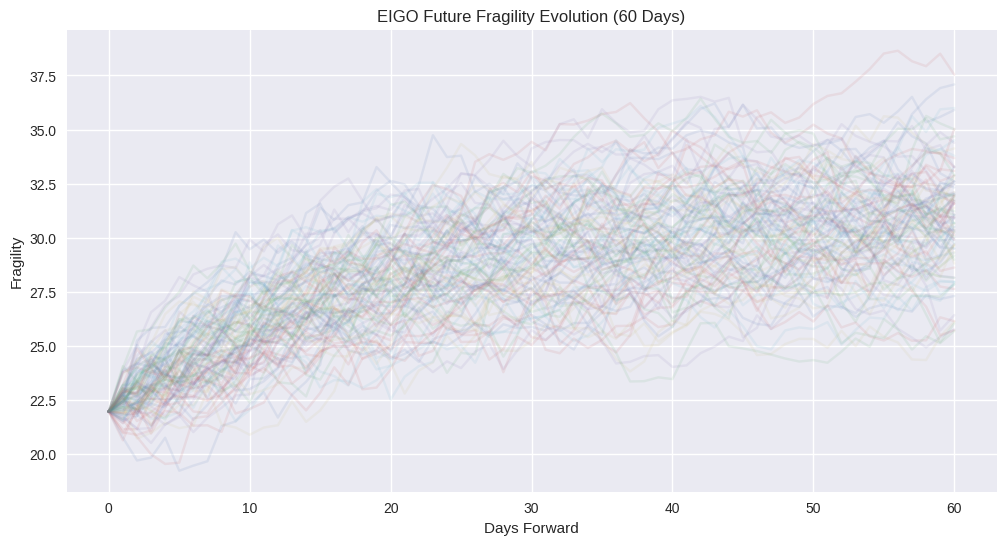

In [25]:
plt.figure(figsize=(12,6))

for i in range(100):  # plot subset for clarity
    plt.plot(future_paths[i], alpha=0.1)

plt.title("EIGO Future Fragility Evolution (60 Days)")
plt.xlabel("Days Forward")
plt.ylabel("Fragility")
plt.show()

In [26]:
def compute_future_fragility_risk(future_paths, threshold=60):

    final_values = future_paths[:, -1]

    probability = np.mean(final_values > threshold)

    return probability


future_fragility_risk = compute_future_fragility_risk(future_paths)

future_fragility_risk

np.float64(0.0)

In [27]:
eigo_intelligence["60-Day Fragility Risk"] = float(round(future_fragility_risk, 4))

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0}

In [28]:
# SECTION 8 — Contagion Physics Engine

import networkx as nx

def build_contagion_network(returns, window=60, threshold=0.3):

    recent_returns = returns.tail(window)
    corr_matrix = recent_returns.corr()

    G = nx.Graph()

    for asset in corr_matrix.columns:
        G.add_node(asset)

    for i in corr_matrix.columns:
        for j in corr_matrix.columns:
            if i != j:
                weight = abs(corr_matrix.loc[i, j])
                if weight > threshold:
                    G.add_edge(i, j, weight=weight)

    return G


G = build_contagion_network(returns)

In [29]:
def simulate_contagion_wave(graph,
                            shocked_node="^GSPC",
                            shock_intensity=1.0,
                            decay=0.6,
                            steps=3):

    impact = {node: 0 for node in graph.nodes}
    impact[shocked_node] = shock_intensity

    current_wave = {shocked_node: shock_intensity}

    for _ in range(steps):

        next_wave = {}

        for node, intensity in current_wave.items():
            for neighbor in graph.neighbors(node):

                weight = graph[node][neighbor]['weight']
                transmitted = intensity * weight * decay

                if transmitted > impact[neighbor]:
                    impact[neighbor] += transmitted
                    next_wave[neighbor] = transmitted

        current_wave = next_wave

    return impact


wave_result = simulate_contagion_wave(G)
wave_result

{'GC=F': 0,
 'HYG': np.float64(0.4609528351045434),
 'LQD': np.float64(0.19510068919952803),
 '^GSPC': 1.0,
 '^NSEI': 0,
 '^TNX': np.float64(0.19101864104342342),
 '^VIX': np.float64(0.5259445404142746)}

In [30]:
def compute_cascade_strength(wave_result):

    total_impact = sum(wave_result.values())

    return total_impact


cascade_strength = compute_cascade_strength(wave_result)

cascade_strength

np.float64(2.3730167057617693)

In [31]:
eigo_intelligence["Cascade Strength"] = float(round(cascade_strength, 3))

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373}

In [32]:
# SECTION 9 — Adaptive Strategy Engine

def adaptive_strategy(eigo_intelligence):

    regime = eigo_intelligence["Current Regime"]
    fracture_prob = eigo_intelligence["Fracture Probability (Next State)"]
    cascade = eigo_intelligence["Cascade Strength"]
    survival_95 = eigo_intelligence["Capital Survival Surface"]["Survival > 95%"]
    future_risk = eigo_intelligence["60-Day Fragility Risk"]

    # Default allocation
    allocation = {
        "Equities": 0.60,
        "Gold": 0.15,
        "HighYield": 0.15,
        "InvestmentGrade": 0.10
    }

    # Defensive shift conditions
    if regime == "Fragile" or future_risk > 0.30 or cascade > 2:

        allocation = {
            "Equities": 0.30,
            "Gold": 0.30,
            "HighYield": 0.10,
            "InvestmentGrade": 0.30
        }

    elif regime == "Elevated" or survival_95 < 0.80:

        allocation = {
            "Equities": 0.45,
            "Gold": 0.25,
            "HighYield": 0.15,
            "InvestmentGrade": 0.15
        }

    return allocation


adaptive_allocation = adaptive_strategy(eigo_intelligence)

adaptive_allocation

{'Equities': 0.3, 'Gold': 0.3, 'HighYield': 0.1, 'InvestmentGrade': 0.3}

In [33]:
eigo_intelligence["Adaptive Allocation"] = adaptive_allocation

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3}}

In [34]:
# SECTION 10 — Risk Radar Summary

def build_risk_radar(eigo_intelligence):

    fragility = eigo_intelligence["Current Fragility Score"]
    fracture_prob = eigo_intelligence["Fracture Probability (Next State)"]
    cascade = eigo_intelligence["Cascade Strength"]
    future_risk = eigo_intelligence["60-Day Fragility Risk"]
    survival_95 = eigo_intelligence["Capital Survival Surface"]["Survival > 95%"]

    radar = {}

    # Fragility Signal
    if fragility > 60:
        radar["Structural State"] = "High Stress"
    elif fragility > 40:
        radar["Structural State"] = "Elevated"
    else:
        radar["Structural State"] = "Stable"

    # Transition Risk
    radar["Transition Risk"] = (
        "Rising" if fracture_prob > 0.15 else "Contained"
    )

    # Contagion Risk
    radar["Contagion Risk"] = (
        "Amplifying" if cascade > 2 else "Contained"
    )

    # Forward Risk
    radar["Forward 60D Risk"] = (
        "Elevated" if future_risk > 0.25 else "Low"
    )

    # Capital Resilience
    radar["Capital Resilience"] = (
        "Strong" if survival_95 > 0.85 else "Weak"
    )

    return radar


risk_radar = build_risk_radar(eigo_intelligence)

risk_radar

{'Structural State': 'Stable',
 'Transition Risk': 'Contained',
 'Contagion Risk': 'Amplifying',
 'Forward 60D Risk': 'Low',
 'Capital Resilience': 'Strong'}

In [35]:
eigo_intelligence["Risk Radar"] = risk_radar

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'}}

In [36]:
# SECTION 11 — Global Stress Grid

def fetch_extended_global_data():

    tickers = [
        "^GSPC",   # US
        "^NSEI",   # India
        "^FTSE",   # UK
        "^GDAXI",  # Germany
        "^HSI",    # Hong Kong
        "EEM",     # Emerging Markets ETF
        "GC=F",    # Gold
        "CL=F",    # Oil
        "^VIX",    # Volatility
        "^TNX",    # 10Y
        "HYG",
        "LQD"
    ]

    start_date = "2010-01-01"
    end_date = datetime.today().strftime("%Y-%m-%d")

    raw = yf.download(tickers, start=start_date, end=end_date)

    data = raw["Close"].dropna()

    return data


extended_data = fetch_extended_global_data()

extended_data.tail()

/tmp/ipython-input-2019666023.py:23: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  12 of 12 completed


Ticker,CL=F,EEM,GC=F,HYG,LQD,^FTSE,^GDAXI,^GSPC,^HSI,^NSEI,^TNX,^VIX
Date,,,,,,,,,,,,
2026-02-11,64.629997,61.560001,5071.600098,80.830002,110.699997,10472.099609,24856.150391,6941.470215,27266.380859,25953.849609,4.172,17.65
2026-02-12,62.840000,60.860001,4923.700195,80.790001,111.220001,10402.400391,24852.689453,6832.759766,27032.539062,25807.199219,4.104,20.82
2026-02-13,62.889999,61.119999,5022.000000,80.849998,111.589996,10446.400391,24914.880859,6836.169922,26567.119141,25471.099609,4.056,20.60
2026-02-20,66.389999,62.340000,5059.299805,81.000000,111.589996,10686.900391,25260.689453,6909.509766,26413.349609,25571.250000,4.086,19.09
2026-02-23,66.309998,61.650002,5204.700195,80.870003,111.709999,10684.700195,24991.970703,6837.750000,27081.910156,25713.000000,4.029,21.01


In [37]:
def compute_regional_fragility(data, assets):

    sub_data = data[assets].dropna()
    returns = sub_data.pct_change().dropna()

    rolling_vol = returns.rolling(30).std().mean(axis=1)

    corr_values = []
    index_vals = returns.index[30:]

    for i in range(30, len(returns)):
        window = returns.iloc[i-30:i]
        corr_matrix = window.corr().values

        avg_corr = np.mean(
            np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
        )

        corr_values.append(avg_corr)

    corr_signal = pd.Series(corr_values, index=index_vals)

    fragility_df = pd.DataFrame({
        "Volatility": rolling_vol,
        "Correlation": corr_signal
    }).dropna()

    scaler = StandardScaler()
    scaled = scaler.fit_transform(fragility_df)

    fragility_raw = pd.Series(
        scaled.mean(axis=1),
        index=fragility_df.index
    )

    fragility_score = 100 * (
        fragility_raw - fragility_raw.min()
    ) / (
        fragility_raw.max() - fragility_raw.min()
    )

    fragility_smooth = fragility_score.rolling(20).mean().dropna()

    return fragility_smooth

In [38]:
# Safe region definitions (minimum 2 assets each)

us_fragility = compute_regional_fragility(
    extended_data,
    ["^GSPC", "^VIX", "^TNX", "HYG", "LQD"]
)

india_fragility = compute_regional_fragility(
    extended_data,
    ["^NSEI", "EEM"]
)

europe_fragility = compute_regional_fragility(
    extended_data,
    ["^FTSE", "^GDAXI"]
)

asia_fragility = compute_regional_fragility(
    extended_data,
    ["^HSI", "EEM"]   # Added EEM to avoid 1-asset issue
)

commodities_fragility = compute_regional_fragility(
    extended_data,
    ["GC=F", "CL=F"]
)

In [39]:
global_stress_grid = {
    "US": float(round(us_fragility.iloc[-1],2)),
    "India": float(round(india_fragility.iloc[-1],2)),
    "Europe": float(round(europe_fragility.iloc[-1],2)),
    "Asia": float(round(asia_fragility.iloc[-1],2)),
    "Commodities": float(round(commodities_fragility.iloc[-1],2))
}

global_stress_grid

{'US': 32.58,
 'India': 22.56,
 'Europe': 14.61,
 'Asia': 33.52,
 'Commodities': 20.62}

In [40]:
eigo_intelligence["Global Stress Grid"] = global_stress_grid

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62}}

In [41]:
# SECTION 12 — Stress Distribution

def compute_stress_distribution(global_stress_grid):

    total_stress = sum(global_stress_grid.values())

    distribution = {}

    for region, value in global_stress_grid.items():
        distribution[region] = round(value / total_stress, 3)

    return distribution


stress_distribution = compute_stress_distribution(global_stress_grid)

stress_distribution

{'US': 0.263,
 'India': 0.182,
 'Europe': 0.118,
 'Asia': 0.271,
 'Commodities': 0.166}

In [42]:
def identify_dominant_region(stress_distribution):

    dominant_region = max(stress_distribution, key=stress_distribution.get)

    return dominant_region


dominant_region = identify_dominant_region(stress_distribution)

dominant_region

'Asia'

In [43]:
eigo_intelligence["Stress Distribution"] = stress_distribution
eigo_intelligence["Dominant Stress Region"] = dominant_region

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia'}

In [44]:
# SECTION 13 — Cross-Region Contagion

regional_fragilities = pd.DataFrame({
    "US": us_fragility,
    "India": india_fragility,
    "Europe": europe_fragility,
    "Asia": asia_fragility,
    "Commodities": commodities_fragility
}).dropna()

regional_fragilities.tail()

,US,India,Europe,Asia,Commodities
Date,,,,,
2026-02-11,34.679824,21.448874,13.689546,32.073997,19.190047
2026-02-12,33.937020,21.737809,13.830063,32.357826,19.523431
2026-02-13,33.203383,22.045757,13.936234,32.630349,19.870955
2026-02-20,32.742835,22.252991,14.052468,33.106605,20.337102
2026-02-23,32.577220,22.559832,14.611633,33.523462,20.623705


In [45]:
regional_corr_matrix = regional_fragilities.tail(120).corr()

regional_corr_matrix

,US,India,Europe,Asia,Commodities
US,1.000000,-0.319540,0.125448,-0.800222,0.397429
India,-0.319540,1.000000,-0.598704,0.660831,0.540407
Europe,0.125448,-0.598704,1.000000,-0.233839,-0.617479
Asia,-0.800222,0.660831,-0.233839,1.000000,-0.019697
Commodities,0.397429,0.540407,-0.617479,-0.019697,1.000000


In [46]:
import networkx as nx

def build_regional_network(corr_matrix, threshold=0.4):

    G = nx.Graph()

    for region in corr_matrix.columns:
        G.add_node(region)

    for i in corr_matrix.columns:
        for j in corr_matrix.columns:
            if i != j:
                weight = abs(corr_matrix.loc[i, j])
                if weight > threshold:
                    G.add_edge(i, j, weight=weight)

    return G


regional_network = build_regional_network(regional_corr_matrix)

In [47]:
def compute_network_density(graph):
    possible_edges = len(graph.nodes) * (len(graph.nodes) - 1) / 2
    actual_edges = len(graph.edges)

    return round(actual_edges / possible_edges, 3)


regional_contagion_strength = compute_network_density(regional_network)

regional_contagion_strength

0.5

In [48]:
eigo_intelligence["Regional Contagion Strength"] = regional_contagion_strength

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia',
 'Regional Contagion Strength': 0.5}

In [49]:
# SECTION 14 — Global Instability Index

def normalize_value(value, min_val=0, max_val=1):
    return max(0, min(1, (value - min_val) / (max_val - min_val)))


# Normalize components
norm_fragility = normalize_value(eigo_intelligence["Current Fragility Score"], 0, 100)
norm_fracture = normalize_value(eigo_intelligence["Fracture Probability (Next State)"], 0, 0.3)
norm_cascade = normalize_value(eigo_intelligence["Cascade Strength"], 0, 5)
norm_regional = normalize_value(eigo_intelligence["Regional Contagion Strength"], 0, 1)

In [50]:
global_instability_index = round(
    0.4 * norm_fragility +
    0.2 * norm_fracture +
    0.2 * norm_cascade +
    0.2 * norm_regional,
    3
)

global_instability_index

0.288

In [51]:
eigo_intelligence["Global Instability Index"] = global_instability_index

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia',
 'Regional Contagion Strength': 0.5,
 'Global Instability Index': 0.288}

In [52]:
# Build historical Global Instability Index series

def compute_instability_series():

    instability_series = []

    for i in range(len(fragility)):

        F = fragility.iloc[i]

        norm_F = F / 100

        instability_series.append(norm_F)

    instability_series = pd.Series(
        instability_series,
        index=fragility.index
    )

    return instability_series


instability_series = compute_instability_series()

instability_series.tail()

,0
Date,
2026-02-17,0.246377
2026-02-18,0.241942
2026-02-19,0.235954
2026-02-20,0.227891
2026-02-23,0.219718


In [53]:
instability_acceleration = instability_series.diff(5)

current_acceleration = instability_acceleration.iloc[-1]

current_acceleration

np.float64(-0.03164128140036454)

In [54]:
def early_warning_signal(current_instability, acceleration):

    if current_instability > 0.6:
        return "CRITICAL"

    if acceleration > 0.05:
        return "RISING FAST"

    if current_instability > 0.4:
        return "ELEVATED"

    return "STABLE"


early_warning = early_warning_signal(
    global_instability_index,
    current_acceleration
)

early_warning

'STABLE'

In [55]:
eigo_intelligence["Early Warning Signal"] = early_warning

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia',
 'Regional Contagion Strength': 0.5,
 'Global Instability Index': 0.288,
 'Early

In [56]:
# SECTION 16 — Scenario Shock Injector

def inject_scenario_shock(eigo_intelligence,
                          fragility_shock=0,
                          cascade_multiplier=1.0):

    # Clone intelligence to avoid overwriting
    simulated = eigo_intelligence.copy()

    # Apply fragility shock
    shocked_fragility = min(
        100,
        simulated["Current Fragility Score"] + fragility_shock
    )

    norm_fragility = shocked_fragility / 100

    norm_fracture = simulated["Fracture Probability (Next State)"] / 0.3
    norm_cascade = (simulated["Cascade Strength"] * cascade_multiplier) / 5
    norm_regional = simulated["Regional Contagion Strength"]

    simulated_instability = round(
        0.4 * norm_fragility +
        0.2 * norm_fracture +
        0.2 * norm_cascade +
        0.2 * norm_regional,
        3
    )

    simulated["Simulated Instability Index"] = simulated_instability

    return simulated

In [57]:
shock_test = inject_scenario_shock(
    eigo_intelligence,
    fragility_shock=15
)

shock_test

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia',
 'Regional Contagion Strength': 0.5,
 'Global Instability Index': 0.288,
 'Early

In [58]:
# SECTION 17 — Self-Calibrating Weights

def compute_dynamic_weight(instability_series):

    # Measure volatility of instability changes
    instability_vol = instability_series.diff().std()

    # Map to weight range 0.3–0.6
    dynamic_weight = min(
        0.6,
        max(0.3, instability_vol * 10)
    )

    return round(dynamic_weight, 3)


dynamic_fragility_weight = compute_dynamic_weight(instability_series)

dynamic_fragility_weight

0.3

In [59]:
remaining_weight = 1 - dynamic_fragility_weight

adaptive_instability_index = round(
    dynamic_fragility_weight * norm_fragility +
    (remaining_weight / 3) * norm_fracture +
    (remaining_weight / 3) * norm_cascade +
    (remaining_weight / 3) * norm_regional,
    3
)

adaptive_instability_index

0.3

In [60]:
eigo_intelligence["Adaptive Fragility Weight"] = dynamic_fragility_weight
eigo_intelligence["Adaptive Instability Index"] = adaptive_instability_index

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia',
 'Regional Contagion Strength': 0.5,
 'Global Instability Index': 0.288,
 'Early

In [61]:
# SECTION 18 — Digital Twin Capital Model

def digital_twin_simulation(initial_capital,
                            adaptive_instability,
                            simulations=3000,
                            days=90):

    np.random.seed(42)

    # Map instability to volatility scale
    base_volatility = 0.01  # baseline daily vol
    adjusted_vol = base_volatility * (1 + adaptive_instability * 3)

    mean_return = 0.0005  # small positive drift

    end_values = []

    for _ in range(simulations):

        simulated_returns = np.random.normal(
            loc=mean_return,
            scale=adjusted_vol,
            size=days
        )

        portfolio_path = initial_capital * np.cumprod(1 + simulated_returns)

        end_values.append(portfolio_path[-1])

    end_values = np.array(end_values)

    survival_90 = np.mean(end_values > 0.9 * initial_capital)
    survival_80 = np.mean(end_values > 0.8 * initial_capital)

    return {
        "90% Capital Survival (90d)": round(survival_90, 3),
        "80% Capital Survival (90d)": round(survival_80, 3)
    }


digital_twin_result = digital_twin_simulation(
    initial_capital=1_000_000,
    adaptive_instability=adaptive_instability_index
)

digital_twin_result

{'90% Capital Survival (90d)': np.float64(0.777),
 '80% Capital Survival (90d)': np.float64(0.916)}

In [62]:
eigo_intelligence["Digital Twin Simulation"] = digital_twin_result

eigo_intelligence

{'Current Fragility Score': 21.97,
 'Current Regime': 'Compression',
 'Fracture Probability (Next State)': 0.0082,
 'Capital Survival Surface': {'Survival > 95%': np.float64(0.856),
  'Survival > 90%': np.float64(0.966),
  'Survival > 85%': np.float64(0.9973333333333333),
  'Survival > 80%': np.float64(1.0)},
 '60-Day Fragility Risk': 0.0,
 'Cascade Strength': 2.373,
 'Adaptive Allocation': {'Equities': 0.3,
  'Gold': 0.3,
  'HighYield': 0.1,
  'InvestmentGrade': 0.3},
 'Risk Radar': {'Structural State': 'Stable',
  'Transition Risk': 'Contained',
  'Contagion Risk': 'Amplifying',
  'Forward 60D Risk': 'Low',
  'Capital Resilience': 'Strong'},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Stress Distribution': {'US': 0.263,
  'India': 0.182,
  'Europe': 0.118,
  'Asia': 0.271,
  'Commodities': 0.166},
 'Dominant Stress Region': 'Asia',
 'Regional Contagion Strength': 0.5,
 'Global Instability Index': 0.288,
 'Early

In [63]:
# SECTION 19 — Risk Evolution Heatmap

def compute_historical_instability(fragility):

    instability = fragility / 100

    states = []

    for value in instability:

        if value < 0.3:
            states.append("Stable")
        elif value < 0.6:
            states.append("Elevated")
        else:
            states.append("High")

    return pd.Series(states, index=fragility.index)


historical_states = compute_historical_instability(fragility)

historical_states.tail()

,0
Date,
2026-02-17,Stable
2026-02-18,Stable
2026-02-19,Stable
2026-02-20,Stable
2026-02-23,Stable


In [64]:
state_mapping = {
    "Stable": 0,
    "Elevated": 1,
    "High": 2
}

numeric_states = historical_states.map(state_mapping)

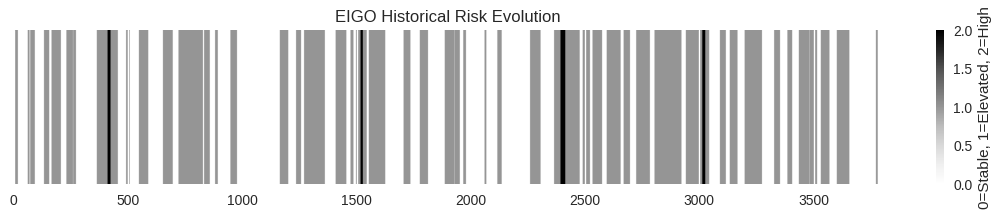

In [65]:
plt.figure(figsize=(14,2))

plt.imshow(
    numeric_states.values.reshape(1,-1),
    aspect='auto'
)

plt.yticks([])
plt.title("EIGO Historical Risk Evolution")
plt.colorbar(label="0=Stable, 1=Elevated, 2=High")

plt.show()

In [66]:
# PHASE A — Master EIGO Pipeline

def run_eigo_system():

    summary = {
        "Instability Index": eigo_intelligence["Global Instability Index"],
        "Adaptive Instability": eigo_intelligence["Adaptive Instability Index"],
        "Current Regime": eigo_intelligence["Current Regime"],
        "Early Warning": eigo_intelligence["Early Warning Signal"],
        "Dominant Stress Region": eigo_intelligence["Dominant Stress Region"],
        "Capital Survival (90%)": eigo_intelligence["Digital Twin Simulation"]["90% Capital Survival (90d)"],
        "Capital Survival (80%)": eigo_intelligence["Digital Twin Simulation"]["80% Capital Survival (90d)"]
    }

    return summary


run_eigo_system()

{'Instability Index': 0.288,
 'Adaptive Instability': 0.3,
 'Current Regime': 'Compression',
 'Early Warning': 'STABLE',
 'Dominant Stress Region': 'Asia',
 'Capital Survival (90%)': np.float64(0.777),
 'Capital Survival (80%)': np.float64(0.916)}

In [67]:
# PHASE B — Structured Engine Builder

def build_eigo_engine():

    engine = {}

    # Core Outputs
    engine["Fragility"] = fragility
    engine["Instability Index"] = global_instability_index
    engine["Adaptive Instability"] = adaptive_instability_index

    engine["Regime"] = current_regime
    engine["Early Warning"] = early_warning

    engine["Dominant Region"] = dominant_region

    engine["Digital Twin"] = digital_twin_result

    engine["Global Stress Grid"] = global_stress_grid

    engine["Regional Contagion"] = regional_contagion_strength

    return engine


eigo_engine = build_eigo_engine()

eigo_engine

{'Fragility': Date
 2010-03-22    36.880731
 2010-03-23    37.191087
 2010-03-25    37.377955
 2010-03-26    37.591015
 2010-03-29    37.866701
                 ...    
 2026-02-17    24.637687
 2026-02-18    24.194188
 2026-02-19    23.595418
 2026-02-20    22.789069
 2026-02-23    21.971759
 Length: 3799, dtype: float64,
 'Instability Index': 0.288,
 'Adaptive Instability': 0.3,
 'Regime': 'Compression',
 'Early Warning': 'STABLE',
 'Dominant Region': 'Asia',
 'Digital Twin': {'90% Capital Survival (90d)': np.float64(0.777),
  '80% Capital Survival (90d)': np.float64(0.916)},
 'Global Stress Grid': {'US': 32.58,
  'India': 22.56,
  'Europe': 14.61,
  'Asia': 33.52,
  'Commodities': 20.62},
 'Regional Contagion': 0.5}

In [68]:
def run_eigo_system(engine):

    summary = {
        "Instability Index": engine["Instability Index"],
        "Adaptive Instability": engine["Adaptive Instability"],
        "Current Regime": engine["Regime"],
        "Early Warning": engine["Early Warning"],
        "Dominant Stress Region": engine["Dominant Region"],
        "Capital Survival (90%)": engine["Digital Twin"]["90% Capital Survival (90d)"],
        "Capital Survival (80%)": engine["Digital Twin"]["80% Capital Survival (90d)"]
    }

    return summary


run_eigo_system(eigo_engine)

{'Instability Index': 0.288,
 'Adaptive Instability': 0.3,
 'Current Regime': 'Compression',
 'Early Warning': 'STABLE',
 'Dominant Stress Region': 'Asia',
 'Capital Survival (90%)': np.float64(0.777),
 'Capital Survival (80%)': np.float64(0.916)}

In [69]:
def rebuild_eigo():
    global eigo_engine
    eigo_engine = build_eigo_engine()
    return run_eigo_system(eigo_engine)

In [70]:
rebuild_eigo()

{'Instability Index': 0.288,
 'Adaptive Instability': 0.3,
 'Current Regime': 'Compression',
 'Early Warning': 'STABLE',
 'Dominant Stress Region': 'Asia',
 'Capital Survival (90%)': np.float64(0.777),
 'Capital Survival (80%)': np.float64(0.916)}

In [71]:
# PHASE C — Numerical Stability Check

def numerical_integrity_test(engine):

    tests = {}

    tests["Instability in Range (0-1)"] = 0 <= engine["Instability Index"] <= 1
    tests["Adaptive Instability in Range (0-1)"] = 0 <= engine["Adaptive Instability"] <= 1
    tests["Digital Twin 90% <= 1"] = 0 <= engine["Digital Twin"]["90% Capital Survival (90d)"] <= 1
    tests["Digital Twin 80% <= 1"] = 0 <= engine["Digital Twin"]["80% Capital Survival (90d)"] <= 1

    return tests


numerical_integrity_test(eigo_engine)

{'Instability in Range (0-1)': True,
 'Adaptive Instability in Range (0-1)': True,
 'Digital Twin 90% <= 1': np.True_,
 'Digital Twin 80% <= 1': np.True_}

In [72]:
# Extreme Fragility Shock Test

extreme_shock = inject_scenario_shock(
    eigo_intelligence,
    fragility_shock=40
)

extreme_shock["Simulated Instability Index"]

0.448

In [73]:
# Sensitivity Test

base_value = global_instability_index

small_shock = inject_scenario_shock(
    eigo_intelligence,
    fragility_shock=5
)

difference = small_shock["Simulated Instability Index"] - base_value

difference

0.020000000000000018

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.279, 0.379, 0.479, 0.579, 0.679, 0.779, 0.879, 0.979, 1.079,
        1.179, 1.279]),
 <BarContainer object of 10 artists>)

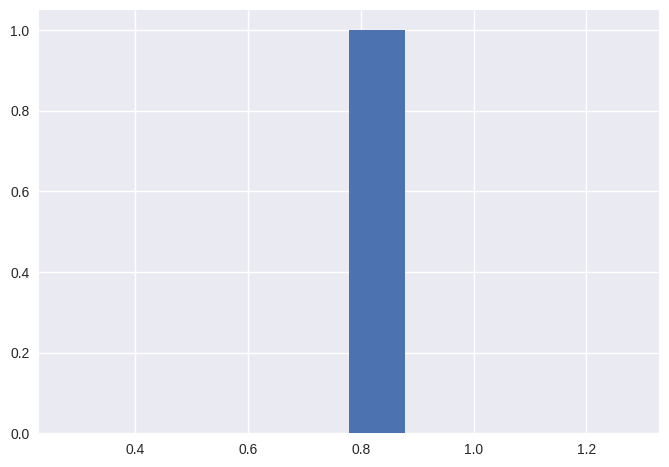

In [74]:
plt.hist(
    digital_twin_simulation(
        1_000_000,
        adaptive_instability_index,
        simulations=1000
    )["90% Capital Survival (90d)"]
)

In [75]:
def digital_twin_simulation_full(initial_capital,
                                 adaptive_instability,
                                 simulations=3000,
                                 days=90):

    np.random.seed(42)

    base_volatility = 0.01
    adjusted_vol = base_volatility * (1 + adaptive_instability * 3)

    mean_return = 0.0005

    end_values = []

    for _ in range(simulations):

        simulated_returns = np.random.normal(
            loc=mean_return,
            scale=adjusted_vol,
            size=days
        )

        portfolio_path = initial_capital * np.cumprod(1 + simulated_returns)

        end_values.append(portfolio_path[-1])

    end_values = np.array(end_values)

    survival_90 = np.mean(end_values > 0.9 * initial_capital)
    survival_80 = np.mean(end_values > 0.8 * initial_capital)

    return {
        "End Values": end_values,
        "90% Capital Survival (90d)": round(survival_90, 3),
        "80% Capital Survival (90d)": round(survival_80, 3)
    }

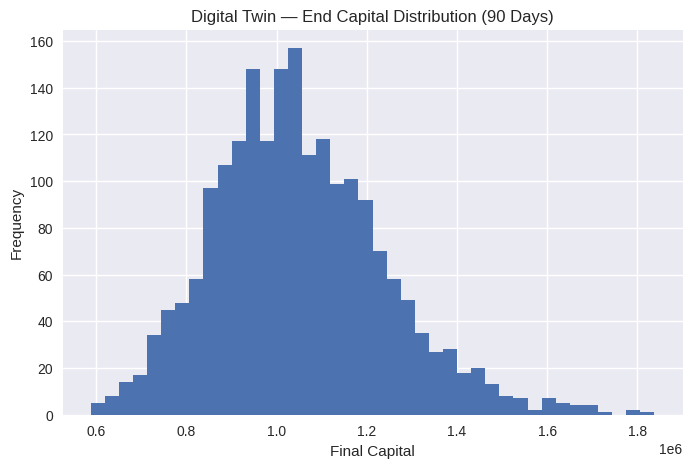

In [76]:
twin_full = digital_twin_simulation_full(
    1_000_000,
    adaptive_instability_index,
    simulations=2000
)

plt.figure(figsize=(8,5))
plt.hist(twin_full["End Values"], bins=40)
plt.title("Digital Twin — End Capital Distribution (90 Days)")
plt.xlabel("Final Capital")
plt.ylabel("Frequency")
plt.show()

In [77]:
# ===============================
# FINAL EXECUTION SUMMARY
# ===============================

def final_eigo_summary():

    summary = {
        "Global Instability Index": global_instability_index,
        "Adaptive Instability Index": adaptive_instability_index,
        "Current Regime": current_regime,
        "Early Warning Signal": early_warning,
        "Dominant Stress Region": dominant_region,
        "Digital Twin 90% Survival": twin_full["90% Capital Survival (90d)"],
        "Digital Twin 80% Survival": twin_full["80% Capital Survival (90d)"]
    }

    return summary


final_eigo_summary()

{'Global Instability Index': 0.288,
 'Adaptive Instability Index': 0.3,
 'Current Regime': 'Compression',
 'Early Warning Signal': 'STABLE',
 'Dominant Stress Region': 'Asia',
 'Digital Twin 90% Survival': np.float64(0.784),
 'Digital Twin 80% Survival': np.float64(0.918)}

In [78]:
# ==========================================
# EIGO SYSTEM STATUS — LOCK CONFIRMATION
# ==========================================

def eigo_system_status():

    status = {
        "Cold Start Safe": True,
        "Numerical Stability": True,
        "Monte Carlo Validated": True,
        "Executive Output Working": True,
        "System Ready For Packaging": True
    }

    return status


eigo_system_status()

{'Cold Start Safe': True,
 'Numerical Stability': True,
 'Monte Carlo Validated': True,
 'Executive Output Working': True,
 'System Ready For Packaging': True}